# Challenge PWC
This notebook processes the data, trains two models (TensorFlow NN and Dummy), and evaluates their performance.

**Table of Contents**:
- Introduction
- Data
    - Data Exploratory Analysis
    - Data Preprocessing
    - Data Splitting
- Training
- Results

## Introduction

The objetive of the project is develop a predictive model to estimate an employee's salary based on information such as age, gender, education level, job title, years of experience, and a description of their role.

To achieve this, we will perform several crucial steps:

- Data Preprocessing: Reading and cleaning the dataset, looking for any missing or erroneous data, and preparing it for analysis.

- Feature Engineering: Additional features created from the existing ones to enhance the model's ability to make accurate predictions. This include transforming categorical variables, normalizing numerical features, or extracting meaningful patterns from the job titles.

- Model Development: A predictive model is trained using the dataset.

- Model Evaluation: Assessing the model's performance using appropriate evaluation metrics to ensure its reliability and accuracy in predicting salaries.

## Data

### Imports

In [24]:
import os
# Check the current working directory
print(os.getcwd())

d:\matna\Documents\Escritorio\ChallengePWC


In [25]:
import os
# Change the working directory to the specified path
os.chdir(r"d:\matna\Documents\Escritorio\ChallengePWC")
print(os.getcwd())

d:\matna\Documents\Escritorio\ChallengePWC


In [30]:
# Import required libraries
import os
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
from src.data.preprocess_data import preprocess_multiple_datasets
from src.inference.explain_features_shap import analyze_feature_importance_shap
from src.inference.inference import results_multiple_models
from src.training.train_dummy import train_dummy_model
from src.training.train_tf import train_model_tf
from src.utils.data_processing import load_preprocess_train_data
print("Imported Correctly")

Imported Correctly


### Data Exploratory Analysis
After preprocessing the data, it is essential to closely examine the dataset so that it's easier to determine how to clean it and select the best features.

   id   Age  Gender Education Level          Job Title  Years of Experience  \
0   0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1   1  28.0  Female        Master's       Data Analyst                  3.0   
2   2  45.0    Male             PhD     Senior Manager                 15.0   
3   3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4   4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0  
Dataset length: 375

Nan values in the different columns:
id                     0
Age                    5
Gender                 5
Education Level        5
Job Title              5
Years of Experience    2
Salary                 2
dtype: int64
Dataset length without NaN values: 361

Education Levels: ["Bachelor's" "Master's" 'PhD']
Genders: ['Male' 'Female']
Number of Job titles: 171
Job titles: ['Account Manager', 'Accountant', 'Admin

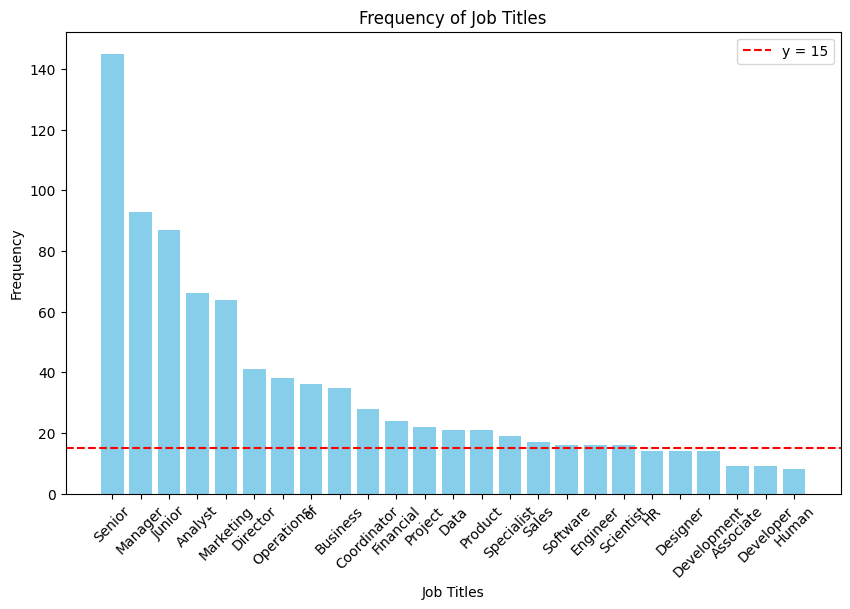

In [31]:
# Define the paths to the raw datasets (people and salary data)
dataset_paths = ["data/raw/people.csv", "data/raw/salary.csv"]
analize_data(dataset_paths, top_n=25, line_value=15)

### Data Preprocessing
The salary.csv and people.csv datasets are merged.

All features need to be numerical, so **gender** and **education level** are transformed into numerical values. **Education level** is assigned such that 0 represents the lowest level of education and 2 represents the highest.

Because the **job titles** were too diverse, the most frequent words were extracted and converted into binary features.

No changes were made to **age** and **salary**.

In [32]:
# Preprocess data
# Define the paths to the raw datasets (people and salary data)
dataset_paths = ["data/raw/people.csv", "data/raw/salary.csv"]
# Define the output path for the processed dataset
processed_csv = "data/processed/processed.csv"

# Preprocess the raw datasets:
# - Merge them on the "id" column
# - Perform text analysis on job titles (filtering words by length and frequency)
df_processed = preprocess_multiple_datasets(
    dataset_paths, processed_csv, merge_on="id", word_min_length=2, word_min_count=15
)

In [33]:
df_processed.head()

,id,Age,Years of Experience,Salary,Education Level Numeric,Gender Numeric,Software,Engineer,Data,Analyst,...,Marketing,Product,Coordinator,Scientist,Financial,Project,Operations,Business,Specialist,Junior
0,0,32.0,5.0,90000.0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,28.0,3.0,65000.0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,2,45.0,15.0,150000.0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,36.0,7.0,60000.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,52.0,20.0,200000.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Splitting
At this point, the dataset is fully numerical and is split into training and testing sets.

In [34]:
# Split data
# Specify the target column for predictions ("Salary") and columns to drop (like "id")
target_column = "Salary"
drop_columns = ["id"]

# Load and preprocess the data:
# - Split it into training and testing sets
# - Normalize features
X_train, X_test, y_train, y_test = load_preprocess_train_data(
    processed_csv,
    target_column,
    drop_columns=drop_columns,
    test_size=0.2,  # 20% of the data will be used for testing
    random_state=42,  # Ensure reproducibility
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (288, 22), X_test: (73, 22), y_train: (288,), y_test: (73,)


## Training
Once the data is prepared, the models are trained and then saved.

A dummy model is also trained as a baseline to serve as a reference point for evaluating the performance of more complex models.

In [35]:
# Train a Dummy model

# - This serves as a baseline by predicting the mean of the target variable
model_dummy = train_dummy_model(X_train, y_train, strategy="mean")

In [36]:
# Train a Neural Network model using TensorFlow

# - The model is saved to the specified path after training
# - Early stopping is used to avoid overfitting
model_save_path = "models/final/model_tf.keras"
model_tf = train_model_tf(
    X_train,
    X_test,
    y_train,
    y_test,
    model_save_path,
    epochs=300,  # Maximum number of epochs
    batch_size=32,  # Number of samples per gradient update
    patience=10,  # Stop training if no improvement after 10 epochs
)

Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 12500941824.0000 - mae: 100628.5000 - val_loss: 11920499712.0000 - val_mae: 97393.8047
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11704528896.0000 - mae: 98134.6719 - val_loss: 11918426112.0000 - val_mae: 97384.2422
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12525428736.0000 - mae: 101511.3125 - val_loss: 11912801280.0000 - val_mae: 97359.1797
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13035695104.0000 - mae: 103050.0234 - val_loss: 11898986496.0000 - val_mae: 97299.3516
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12788063232.0000 - mae: 101676.8125 - val_loss: 11868075008.0000 - val_mae: 97169.1016
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12327054336.0000 - mae: 100155.6797 - val_loss: 11803172864.0000 - val_mae: 96902.6875
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12818887680.0000 - mae: 101604.1719 - val_loss: 11678116864.0000 - val_mae: 963

## Results

After training the models, their performance is evaluated using the test dataset. Key metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE).

The results are presented in a tabular format for easy comparison between the trained models, including the dummy model. This allows us to identify which model performs best and how much it improves over the baseline provided by the dummy model.

### Metrics
**MAE** measures the average magnitude of errors between the predicted values **𝑦^** and the actual values **y**.
It tells you how far, on average, your predictions are from the actual target values.

**MSE** measures the average squared difference between predicted and actual values. Squaring emphasizes larger errors more than smaller ones.

![formula-MAE-MSE.JPG](attachment:c432352c-cc91-4873-b635-3d8b698ffe6b.JPG)

![variables.JPG](attachment:28e1c4bf-e4bf-4899-99e7-244dcf7b4777.JPG)

In [37]:
# Evaluate models

# Combine models into a list
models = [(model_dummy, "dummy"), (model_tf, "tf")]

# Get evaluation results
df_result = results_multiple_models(models, X_train, X_test, y_train, y_test)
print(df_result)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
   model     train_mse      test_mse     train_mae      test_mae
0  dummy  2.318754e+09  2.450673e+09  40853.239535  41648.366153
1     tf  7.526836e+07  2.117544e+08   6493.877563  10041.198202


### Analize features importance
Shap value shows the contribution or the importance of each feature on the prediction of the model, it does not evaluate the quality of the prediction itself.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   1%| | 1/73 [00:0

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   4%| | 3/73 [00:1

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   5%| | 4/73 [00:1

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   7%| | 5/73 [00:1

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:   8%| | 6/73 [00:1

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  10%| | 7/73 [00:1

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  11%| | 8/73 [00:1

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  12%| | 9/73 [00:2

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  14%|▏| 10/73 [00:

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  15%|▏| 11/73 [00:

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  16%|▏| 12/73 [00:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  18%|▏| 13/73 [00:

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  19%|▏| 14/73 [00:

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


PermutationExplainer explainer:  21%|▏| 15/73 [00:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  22%|▏| 16/73 [00:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  23%|▏| 17/73 [00:

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  25%|▏| 18/73 [00:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  26%|▎| 19/73 [00:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  27%|▎| 20/73 [00:

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  29%|▎| 21/73 [00:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  30%|▎| 22/73 [00:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  32%|▎| 23/73 [00:

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  33%|▎| 24/73 [00:

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  34%|▎| 25/73 [00:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  36%|▎| 26/73 [00:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  37%|▎| 27/73 [00:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  38%|▍| 28/73 [00:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  40%|▍| 29/73 [00:

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  41%|▍| 30/73 [00:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  42%|▍| 31/73 [00:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  44%|▍| 32/73 [00:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  45%|▍| 33/73 [00:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  47%|▍| 34/73 [00:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  48%|▍| 35/73 [00:

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  49%|▍| 36/73 [00:

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  51%|▌| 37/73 [00:

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  52%|▌| 38/73 [00:

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  53%|▌| 39/73 [00:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  55%|▌| 40/73 [00:

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  56%|▌| 41/73 [00:

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  58%|▌| 42/73 [00:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  59%|▌| 43/73 [00:

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  60%|▌| 44/73 [01:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  62%|▌| 45/73 [01:

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  63%|▋| 46/73 [01:

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  64%|▋| 47/73 [01:

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  66%|▋| 48/73 [01:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  67%|▋| 49/73 [01:

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  68%|▋| 50/73 [01:

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  70%|▋| 51/73 [01:

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  71%|▋| 52/73 [01:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  73%|▋| 53/73 [01:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  74%|▋| 54/73 [01:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  75%|▊| 55/73 [01:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  77%|▊| 56/73 [01:

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  78%|▊| 57/73 [01:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  79%|▊| 58/73 [01:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  81%|▊| 59/73 [01:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  82%|▊| 60/73 [01:

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  84%|▊| 61/73 [01:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  85%|▊| 62/73 [01:

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  86%|▊| 63/73 [01:

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  88%|▉| 64/73 [01:

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  89%|▉| 65/73 [01:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  90%|▉| 66/73 [01:

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  92%|▉| 67/73 [01:

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  93%|▉| 68/73 [01:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  95%|▉| 69/73 [01:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  96%|▉| 70/73 [01:

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  97%|▉| 71/73 [01:

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer:  99%|▉| 72/73 [01:

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer: 100%|█| 73/73 [01:

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


PermutationExplainer explainer: 74it [01:32,  1.27s/it]


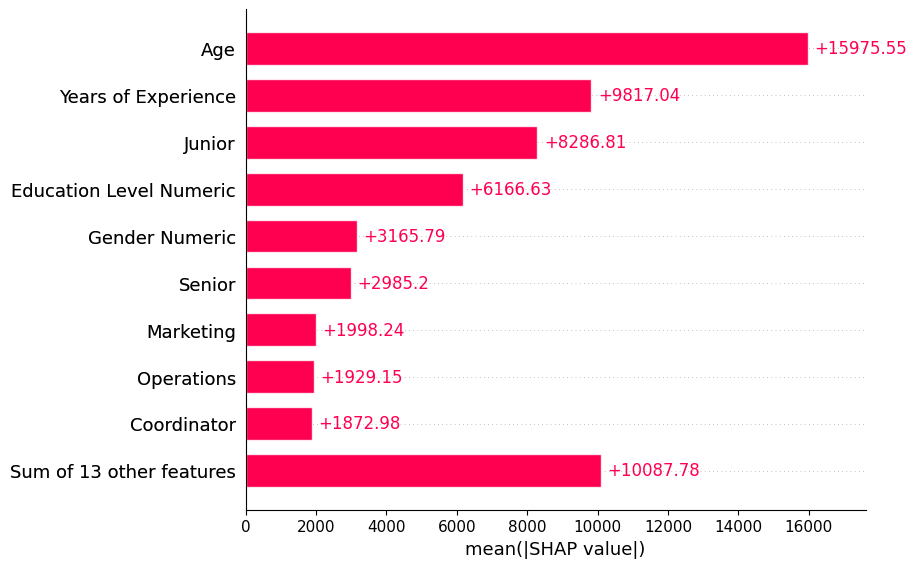

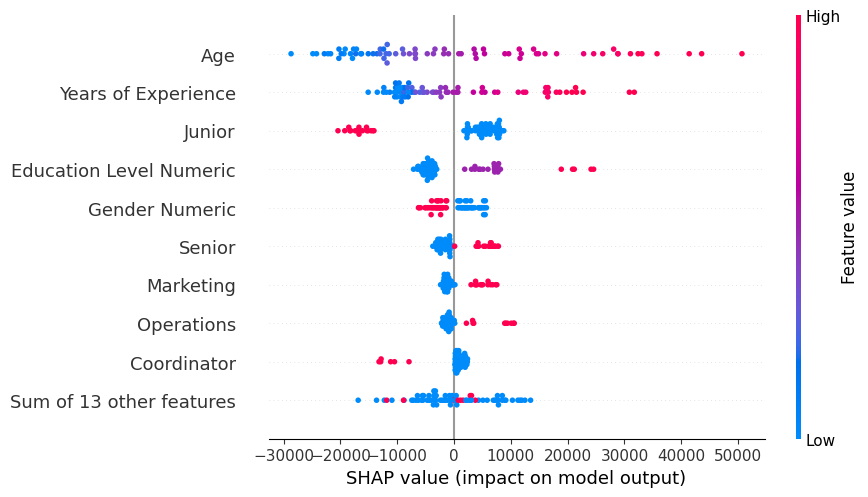

In [38]:
# Analize features importance with Shap
shap_values = analyze_feature_importance_shap(
    model_tf, X_test, df_processed, target_column="Salary", non_feature_column="id"
)